# Monte Carlo Simulation of Cherenkov Ellipse

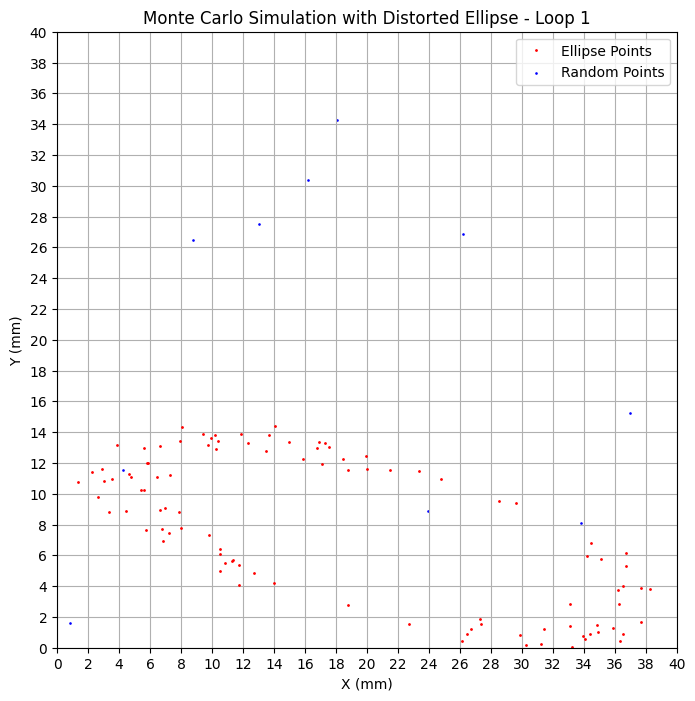

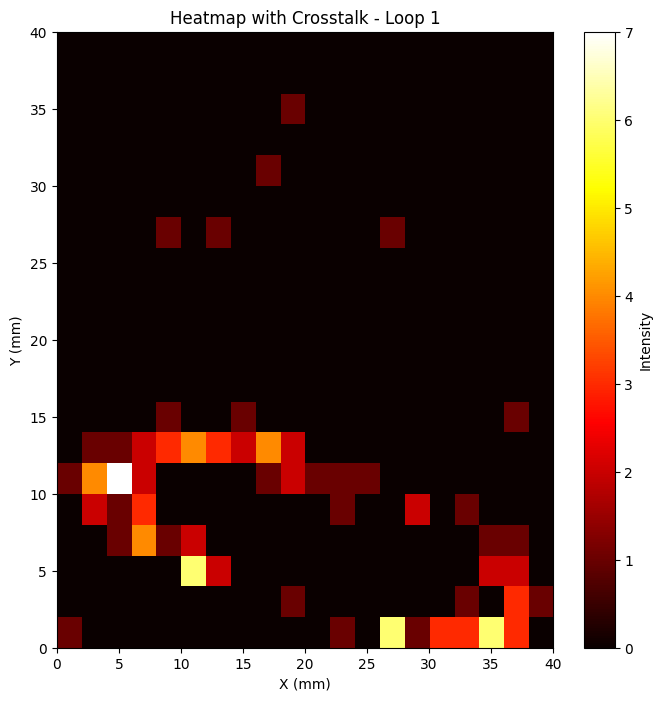

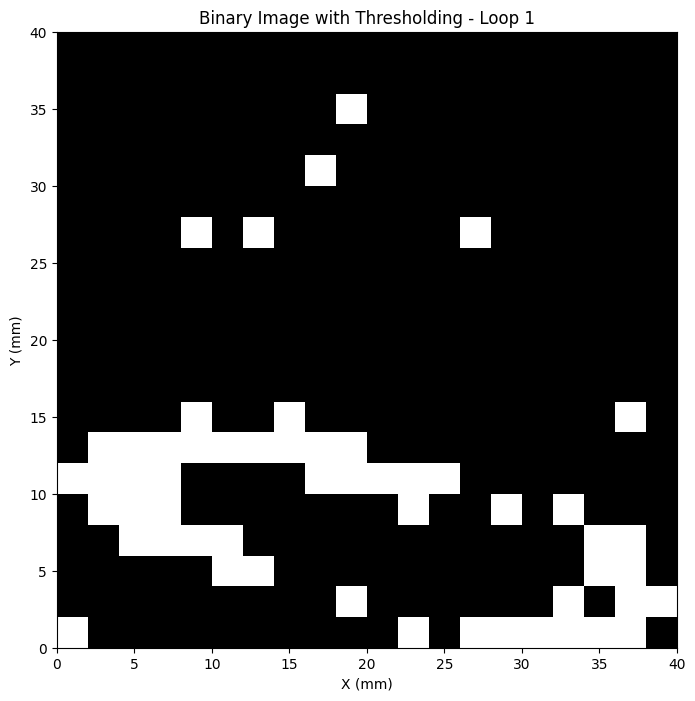

Groundtruth: cx = 20.682394155022905, cy = 7.087204694939716, a = 34.67658660763188, b = 9.609583139372084, theta = 165.18
Current memory usage is 5.431864MB; Peak was 17.177335MB
Elapsed time: 1.85 seconds


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import random
from math import pi
import tracemalloc
import time

# Input Variables for Monte Carlo Simulation
total_points = 110
ellipse_points = 100
semi_major_axis_range = (5, 20)  # Range for semi-major axis length
semi_minor_axis_range = (2, 8)   # Range for semi-minor axis length
theta_range = (0, 360)  # Range for the rotation angle in degrees
space_size = 40  # Space size for random points and boundary for ellipse points
distortion_factor = 0.10  # Allows for a % variation in radii
threshold_value = 25  # Adjustable threshold for binary image

# Input Variables for Crosstalk manipulation
percentage_of_bins = 5  # Percentage of non-zero bins to adjust for crosstalk
value_range = (1, 2)  # Range of values to add to the selected bins, all inclusive

# Input Variables for run
number_of_loops = 1

def run_simulation(number_of_loops):
    tracemalloc.start()  # Start tracking memory allocation
    start_time = time.time()

    for loop in range(number_of_loops):
        # Generate ellipse parameters
        a = random.uniform(*semi_major_axis_range)  # Semi-major axis length
        b = random.uniform(*semi_minor_axis_range)  # Semi-minor axis length
        theta = random.uniform(np.radians(theta_range[0]), np.radians(theta_range[1]))  # Random rotation in radians

        # Place the ellipse within the specified space size
        successful_placement = False
        while not successful_placement:
            # Center of the ellipse randomly placed
            cx = random.uniform(a, space_size - a)
            cy = random.uniform(b, space_size - b)

            # Generate points on the ellipse
            ellipse_angles = np.random.uniform(0, 2 * np.pi, ellipse_points)
            distorted_radii = 1 + np.random.normal(0, distortion_factor, ellipse_points)
            xs_ellipse = a * np.cos(ellipse_angles) * distorted_radii
            ys_ellipse = b * np.sin(ellipse_angles) * distorted_radii

            # Rotate and translate points
            xs_rotated = xs_ellipse * np.cos(theta) - ys_ellipse * np.sin(theta) + cx
            ys_rotated = xs_ellipse * np.sin(theta) + ys_ellipse * np.cos(theta) + cy

            # Check if all points are within the space bounds
            if np.all((0 <= xs_rotated) & (xs_rotated <= space_size)) and np.all((0 <= ys_rotated) & (ys_rotated <= space_size)):
                successful_placement = True

        # Generate random points within the 40x40 space
        xs_random = np.random.uniform(0, space_size, total_points - ellipse_points)
        ys_random = np.random.uniform(0, space_size, total_points - ellipse_points)

        # Plot the ellipse points and random points
        plt.figure(figsize=(8, 8))
        plt.plot(xs_rotated, ys_rotated, 'ro', label='Ellipse Points', markersize=1)
        plt.scatter(xs_random, ys_random, color='blue', label='Random Points', s=0.79)
        plt.xlim(0, space_size)
        plt.ylim(0, space_size)

        # Set major ticks for both axes to be at every 2 units.
        plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(2))
        plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(2))

        plt.title(f'Monte Carlo Simulation with Distorted Ellipse - Loop {loop + 1}')
        plt.xlabel('X (mm)')
        plt.ylabel('Y (mm)')
        plt.legend()
        plt.grid(True)
        plt.show()

        # Prepare data for all points (combining ellipse and random points)
        all_xs = np.concatenate([xs_rotated, xs_random])
        all_ys = np.concatenate([ys_rotated, ys_random])

        # Generate a 2D histogram / heatmap with 2mm x 2mm bins
        heatmap, xedges, yedges = np.histogram2d(all_xs, all_ys, bins=[20, 20], range=[[0, space_size], [0, space_size]])

        # Introducing crosstalk
        non_zero_bins = np.where(heatmap > 0)  # Identify bins with intensity above zero
        num_bins_to_adjust = int(len(non_zero_bins[0]) * (percentage_of_bins / 100.0))  # Calculate the number of bins to adjust based on the percentage

        # Select random indices of these bins
        indices_to_adjust = np.random.choice(range(len(non_zero_bins[0])), num_bins_to_adjust, replace=False)

        # Add a range of integer values to the selected bins
        for idx in indices_to_adjust:
            i, j = non_zero_bins[0][idx], non_zero_bins[1][idx]
            heatmap[i, j] += np.random.randint(*value_range)

        # Plotting the heatmap with crosstalk
        plt.figure(figsize=(8, 8))
        plt.imshow(heatmap.T, origin='lower', cmap='hot', extent=[0, space_size, 0, space_size], aspect='auto')
        plt.colorbar(label='Intensity')
        plt.title(f'Heatmap with Crosstalk - Loop {loop + 1}')
        plt.xlabel('X (mm)')
        plt.ylabel('Y (mm)')
        plt.show()

        # Normalize the heatmap data to a 0-255 range
        heatmap_normalized = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min()) * 255
        heatmap_normalized = heatmap_normalized.astype(int)

        # Binary thresholding
        def apply_binary_threshold(image, threshold):
            # Create a binary image where pixels above the threshold are set to 255 and below to 0
            binary_image = np.zeros_like(image, dtype=np.uint8)
            binary_image[image > threshold] = 1
            return binary_image

        binary_image = apply_binary_threshold(heatmap_normalized.T, threshold_value)

        plt.figure(figsize=(8, 8))
        plt.imshow(binary_image, origin='lower', cmap='gray', extent=[0, space_size, 0, space_size], aspect='auto')
        plt.title(f'Binary Image with Thresholding - Loop {loop + 1}')
        plt.xlabel('X (mm)')
        plt.ylabel('Y (mm)')
        plt.show()

        print(f"Groundtruth: cx = {cx}, cy = {cy}, a = {a*2}, b = {b*2}, theta = {np.degrees(theta):.2f}")

    # Get memory usage
    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Current memory usage is {current / 10**6}MB; Peak was {peak / 10**6}MB")
    print(f"Elapsed time: {elapsed_time:.2f} seconds")

    return binary_image

# Run the simulation and get the binary image
binary_image = run_simulation(number_of_loops)



# Ellipse Hough Transform Algorithm - Multiple worker simulation in python

Top 1 Heatmap:
  Highest Intensity: 44.0
  Coordinates: (10, 3)
  Parameters: Major Axis = 19, Minor Axis = 7, Angle = 166



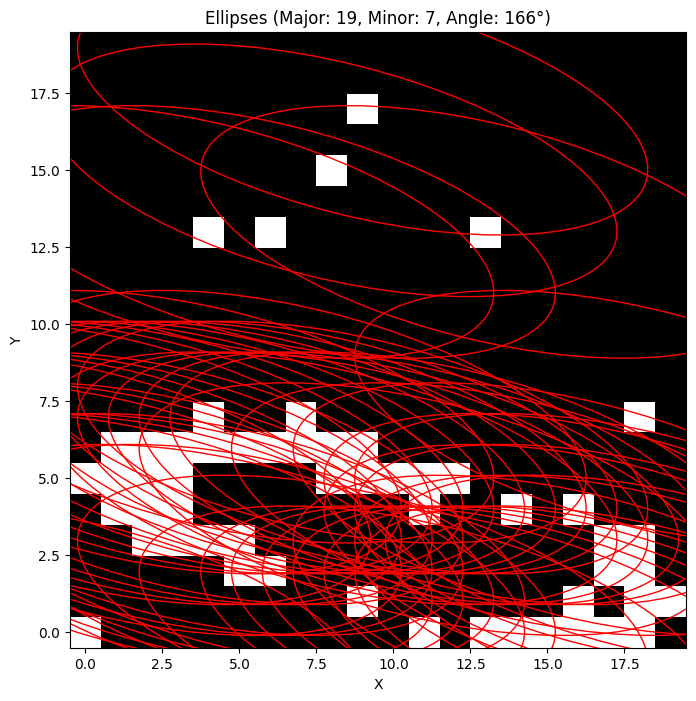

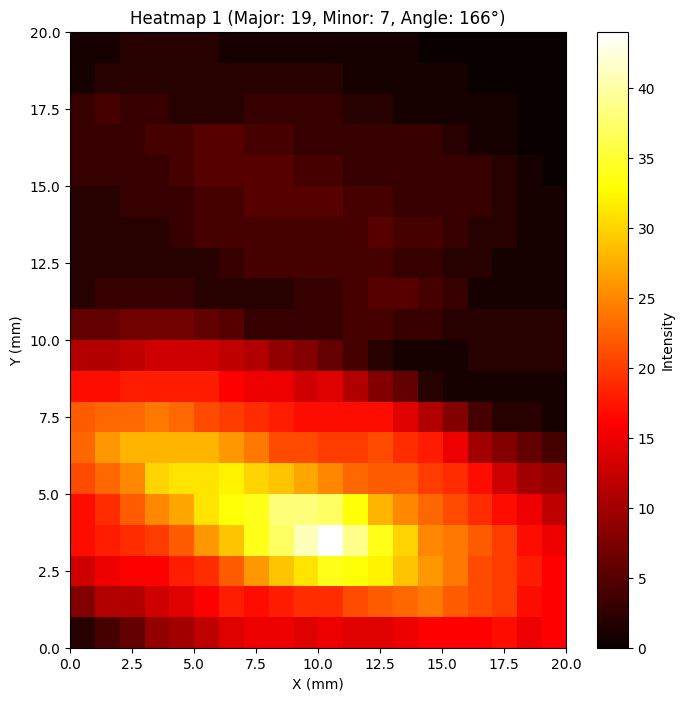

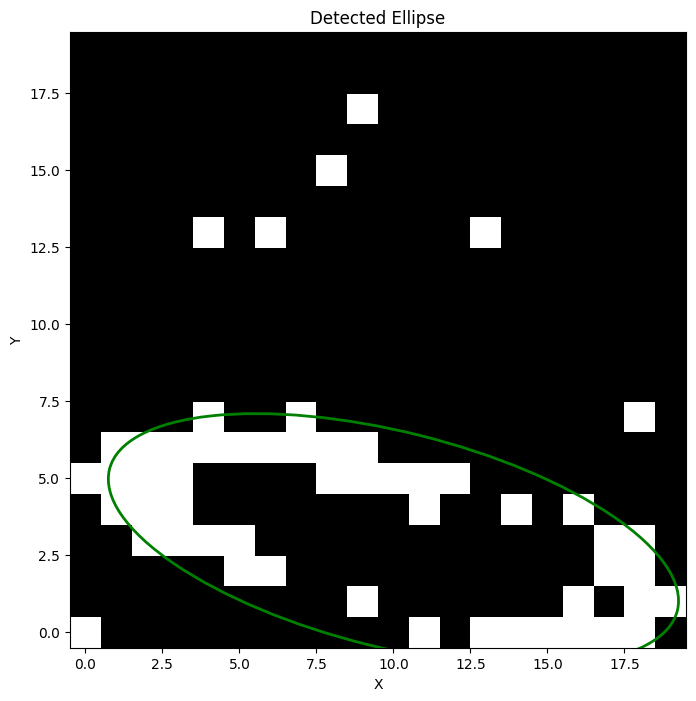

Elapsed time for CPU ellipse detection: 41.34 seconds
Initial memory usage: 452.62 MB
Final memory usage: 606.25 MB
Memory used: 153.62 MB (161083392 bytes)
Current memory usage: 115.74 MB
Peak memory usage: 126.90 MB


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import time
import psutil
import tracemalloc
from multiprocessing import Pool

# Input Variables for Ellipse Hough Transform Hotspot Detection
major_axis_range = np.arange(5, 20)
minor_axis_range = np.arange(2, 8)
rotation_angle_range = np.arange(5, 360, 1)

# Number of heatmaps to display
number_of_heatmaps = 1

def create_ellipse_mask(shape, center, width, height, angle):
    y, x = np.ogrid[:shape[0], :shape[1]]
    y = y - center[0]
    x = x - center[1]
    angle = np.deg2rad(angle)
    cos_angle = np.cos(angle)
    sin_angle = np.sin(angle)
    ellipse_mask = ((x * cos_angle + y * sin_angle)**2 / (width / 2)**2 +
                    (y * cos_angle - x * sin_angle)**2 / (height / 2)**2 <= 1)
    return ellipse_mask

def worker(args):
    binary_image, major_axis, minor_axis, rotation_angle_range, non_zero_bins = args
    heatmap_results = []

    for angle in rotation_angle_range:
        heatmap = np.zeros_like(binary_image, dtype=float)

        for (y, x) in non_zero_bins:
            ellipse_mask = create_ellipse_mask(binary_image.shape, (y, x), major_axis, minor_axis, angle)
            heatmap += ellipse_mask

        max_intensity = np.max(heatmap)
        max_coords = np.unravel_index(np.argmax(heatmap), heatmap.shape)

        heatmap_results.append((max_intensity, max_coords, heatmap, (major_axis, minor_axis, angle)))
    
    return heatmap_results

def detect_ellipse_cpu(binary_image, number_of_heatmaps, num_processes=None):
    start_time = time.time()

    # Start tracemalloc for peak memory usage tracking
    tracemalloc.start()

    # Measure initial memory usage using psutil
    process = psutil.Process()
    initial_memory = process.memory_info().rss

    non_zero_bins = [(i, j) for i in range(binary_image.shape[0]) for j in range(binary_image.shape[1]) if binary_image[i, j] != 0]

    # Split the parameter space among workers
    tasks = []
    for major_axis in major_axis_range:
        for minor_axis in minor_axis_range:
            tasks.append((binary_image, major_axis, minor_axis, rotation_angle_range, non_zero_bins))

    # If num_processes is not specified, it will default to the number of available CPU cores
    with Pool(processes=num_processes) as pool:
        results = pool.map(worker, tasks)

    # Flatten the list of results
    flat_results = [item for sublist in results for item in sublist]

    # Sort and select top heatmaps
    flat_results.sort(reverse=True, key=lambda x: x[0])
    top_heatmaps = flat_results[:number_of_heatmaps]

    for i, (max_intensity, max_coords, heatmap, params) in enumerate(top_heatmaps):
        major_axis, minor_axis, angle = params
        print(f"Top {i+1} Heatmap:")
        print(f"  Highest Intensity: {max_intensity}")
        print(f"  Coordinates: ({max_coords[1]}, {max_coords[0]})")
        print(f"  Parameters: Major Axis = {major_axis}, Minor Axis = {minor_axis}, Angle = {angle}\n")

        fig, ax = plt.subplots(figsize=(8, 8))
        ax.imshow(binary_image, cmap='gray', interpolation='none')

        for (y, x) in non_zero_bins:
            ellipse = Ellipse((x, y), width=major_axis, height=minor_axis, angle=angle, edgecolor='r', facecolor='none')
            ax.add_patch(ellipse)

        plt.title(f'Ellipses (Major: {major_axis}, Minor: {minor_axis}, Angle: {angle}°)')
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.gca().invert_yaxis()
        plt.show()

        plt.figure(figsize=(8, 8))
        plt.imshow(heatmap, origin='lower', cmap='hot', extent=[0, binary_image.shape[1], 0, binary_image.shape[0]], aspect='auto')
        plt.colorbar(label='Intensity')
        plt.title(f'Heatmap {i+1} (Major: {major_axis}, Minor: {minor_axis}, Angle: {angle}°)')
        plt.xlabel('X (mm)')
        plt.ylabel('Y (mm)')
        plt.show()

        fig, ax = plt.subplots(figsize=(8, 8))
        ax.imshow(binary_image, cmap='gray', interpolation='none')
        detected_ellipse = Ellipse(max_coords[::-1], width=major_axis, height=minor_axis, angle=angle, edgecolor='g', facecolor='none', linewidth=2)
        ax.add_patch(detected_ellipse)

        plt.title('Detected Ellipse')
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.gca().invert_yaxis()
        plt.show()

    end_time = time.time()
    elapsed_time = end_time - start_time

    # Measure final memory usage using psutil
    final_memory = process.memory_info().rss
    memory_used = final_memory - initial_memory

    # Get peak memory usage using tracemalloc
    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()

    print(f"Elapsed time for CPU ellipse detection: {elapsed_time:.2f} seconds")
    print(f"Initial memory usage: {initial_memory / (1024 * 1024):.2f} MB")
    print(f"Final memory usage: {final_memory / (1024 * 1024):.2f} MB")
    print(f"Memory used: {memory_used / (1024 * 1024):.2f} MB ({memory_used} bytes)")
    print(f"Current memory usage: {current / (1024 * 1024):.2f} MB")
    print(f"Peak memory usage: {peak / (1024 * 1024):.2f} MB")

# Run the CPU ellipse detection algorithm with a specified number of processes
detect_ellipse_cpu(binary_image, number_of_heatmaps, num_processes=8)
